# Measure Boxes 2.5D

This example demonstrates how to use NxLib and OpenCV to measure the dimensions and position of a single freestanding and rectangular box. We learn how to open a camera using NxLib, capture a depth image and create a 2.5D projection of the data. In the projection we search for the box under the premise that the capture only contains the box and otherwise an empty background.

## Key Learnings
- Basic camera handling and capture
- Usage of a calibration pattern for setting up a practical workspace coordinate system
- Usage of the 2.5D projections from *RenderPointMap*

## Preparations

Before capturing a measurement we need to set up the workspace of the camera. The position in which the camera is mounted does not matter for this example, as long as it is mounted well above the boxes height, so that the top of the box is fully visible. The perspective of the camera is corrected by setting up the workspace coordinate system to be on the ground below the box, with the x- and y-axis parallel to the ground.
This is done in ***NxView*** via the *Workspace Calibration* tab using a calibration pattern. Place the calibration pattern on the ground plane on which the box will be placed for measuring. Then use the button *Set origin with calibration plate* the set the origin to the current location of the pattern. The orientation and position of the pattern do not matter for this example, as long as the pattern is placed on the ground on which the box will be placed. This ensures that the ground plane will be zeroed for the z-values that are not part of the box, which makes separating boxes from the background trivial. Furthermore, this ensures that the measurement is in-plane and not skewed from the perspective of the camera.

## Python environment

The example expects a ***Python*** environment of version 3.10 or greater. The following packages will be used:
- NxLib (nxlib)
- Numpy (numpy)
- OpenCV (cv2)

In [9]:
import nxlib
from nxlib import constants as nxc

import numpy as np
import cv2

# Imports for plotting
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# The modified renderer options are only necessary for rendering static images for GitHub
renderer = pio.renderers["png"]
renderer.width = 1600
renderer.height = 700
renderer.engine = 'kaleido'    # static image generation dependency
pio.renderers.default = "png"  # render to svg instead of interactive plot


## Capture

Open the camera via NxLib and capture a measurement.

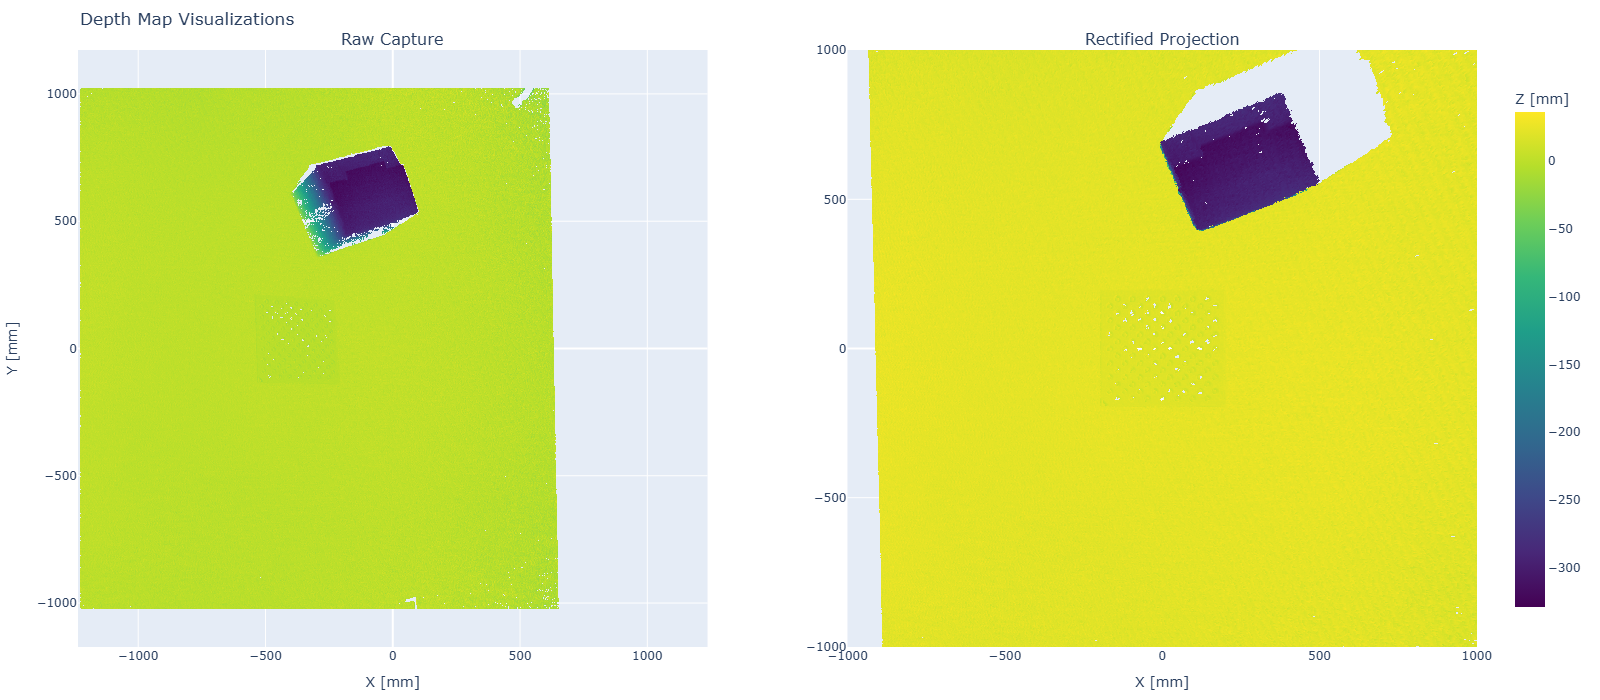

In [10]:
CAM_SERIAL = "Filemeasure_box246111"
IMG_SIZE = [2000, 2000]
PIXEL_SIZE_MM = 1

# Open NxLib and a camera using the same context
with nxlib.NxLib(), nxlib.Camera.from_serial(CAM_SERIAL, [nxc.VAL_STRUCTURED_LIGHT, nxc.VAL_STEREO]) as cam:

    camera_node = cam.get_node()
    camera_node["Parameters"]["SurfaceConnectivity"].set_double(20)

    # Capture image
    cam.capture()
    cam.rectify()
    cam.compute_disparity_map()
    cam.compute_point_map()
    regular_point_map = cam.get_point_map()

    # Run RenderPointMap command to calculate the rectified/projected point map
    params = {
        "PixelSize": PIXEL_SIZE_MM,
        "Size": IMG_SIZE,
        "ViewPose": {
            "Rotation": {
                "Angle": 0,
                "Axis": [0, 0, 0]
            },
            "Translation": [0, 0, 0]
        }
    }

    with nxlib.NxLibCommand(nxc.CMD_RENDER_POINT_MAP, params=params) as cmd:
        cmd.execute()
        projected_point_map = cmd.result()["Images"]["RenderPointMap"].get_binary_data()
        projected_texture = cmd.result()["Images"]["RenderPointMapTexture"].get_binary_data()[:, :, :3]
        projected_texture = np.ascontiguousarray(projected_texture)


# Plots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Raw Capture", "Rectified Projection"))

# Left subplot: regular_point_map Z values
H, W = regular_point_map.shape[:2]
fig.add_trace(go.Heatmap(
        z=regular_point_map[:, :, 2],
        x=np.linspace(-W / 2 * PIXEL_SIZE_MM, W / 2 * PIXEL_SIZE_MM, W),
        y=np.linspace(-H / 2 * PIXEL_SIZE_MM, H / 2 * PIXEL_SIZE_MM, H),
        colorscale='Viridis',
        colorbar=dict(title='Z [mm]', len=0.9)),
    row=1, col=1)

# Right subplot: projected_point_map Z values with scaling in mm
H, W = projected_point_map.shape[:2]
fig.add_trace(go.Heatmap(
        z=projected_point_map[:, :, 2],
        x=np.linspace(-W / 2 * PIXEL_SIZE_MM, W / 2 * PIXEL_SIZE_MM, W),
        y=np.linspace(-H / 2 * PIXEL_SIZE_MM, H / 2 * PIXEL_SIZE_MM, H),
        colorscale='Viridis',
        showscale=False),
    row=1, col=2)

fig.update_layout(
    title="Depth Map Visualizations",
    margin=dict(l=20, r=20, t=50, b=50),
    xaxis=dict(scaleanchor='y', scaleratio=1),
)
fig.update_xaxes(title_text="X [mm]", row=1, col=1)
fig.update_yaxes(title_text="Y [mm]", row=1, col=1)
fig.update_xaxes(title_text="X [mm]", row=1, col=2)
fig.show()

## Simple: Estimation of the Box Volume

This section demonstrates a basic method to estimate the volume of a package using a projected 2.5D point map. We start by converting the depth information into a height map, where each pixel represents the height of a surface point above a reference plane. To isolate the package from the background, we apply a threshold to ignore areas below a minimum package height, then clean the resulting binary mask using morphological operations to remove noise. Finally, we compute the volume by summing the height values within the detected package area and converting the result to liters based on the known pixel size.

In [11]:
PACKAGE_MIN_HEIGHT_MM = 25

# Create height image
height_image = -1 * projected_point_map[:, :, 2]
height_image[np.isnan(height_image)] = 0

# Binarize height image
_, binarized_height_image = cv2.threshold(height_image, PACKAGE_MIN_HEIGHT_MM, 255, cv2.THRESH_BINARY)
binarized_height_image = np.asarray(binarized_height_image, dtype=np.uint8)

# Remove noise from image
kernel = np.ones((5, 5), np.uint8)
cleaned_height_image = cv2.morphologyEx(binarized_height_image, cv2.MORPH_OPEN, kernel)
cleaned_height_image = cv2.morphologyEx(cleaned_height_image, cv2.MORPH_CLOSE, kernel)

# Estimate volume of the box
volume_dm3 = np.sum(height_image * binarized_height_image / 255) * PIXEL_SIZE_MM * PIXEL_SIZE_MM / 1_000_000
print(f"Estimated volume of the box: {volume_dm3:.1f}L")

# Plots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Raw Capture", "Rectified Projection"))

# Left subplot: regular_point_map Z values
H, W = regular_point_map.shape[:2]
fig.add_trace(go.Heatmap(
        z=regular_point_map[:, :, 2],
        x=np.linspace(-W / 2 * PIXEL_SIZE_MM, W / 2 * PIXEL_SIZE_MM, W),
        y=np.linspace(-H / 2 * PIXEL_SIZE_MM, H / 2 * PIXEL_SIZE_MM, H),
        colorscale='Viridis',
        colorbar=dict(title='Z [mm]', len=0.9)),
    row=1, col=1)

# Right subplot: projected_point_map Z values with scaling in mm
H, W = projected_point_map.shape[:2]
fig.add_trace(go.Heatmap(
        z=projected_point_map[:, :, 2],
        x=np.linspace(-W / 2 * PIXEL_SIZE_MM, W / 2 * PIXEL_SIZE_MM, W),
        y=np.linspace(-H / 2 * PIXEL_SIZE_MM, H / 2 * PIXEL_SIZE_MM, H),
        colorscale='Viridis',
        showscale=False),
    row=1, col=2)

fig.update_layout(
    title="Depth Map Visualizations",
    margin=dict(l=20, r=20, t=50, b=50),
    xaxis=dict(scaleanchor='y', scaleratio=1),
)
fig.update_xaxes(title_text="X [mm]", row=1, col=1)
fig.update_yaxes(title_text="Y [mm]", row=1, col=1)
fig.update_xaxes(title_text="X [mm]", row=1, col=2)
fig.show()


Estimated volume of the box: 41.8L


## Advanced: Measurement of the Box Dimensions and Position

In this section, we extend the measured metrics. Now we are also detecting the exact position, size, and orientation of the largest object in the scene—presumably the package. We begin by identifying all contours in the binarized height image and selecting the one with the largest area. From this, we compute the object’s minimum bounding rectangle to extract its dimensions and orientation. A mask is then applied to isolate only the relevant height values of the selected object, which allows for a more precise volume calculation. Finally, the result is visualized by drawing the detected object and its bounding box onto the image.

Box Position: [622.0mm, 245.0mm]; Rotation: 22.6°
Box Size LWH: 441.8mm x 341.5mm x 300.0mm (Volume: 45.3L)


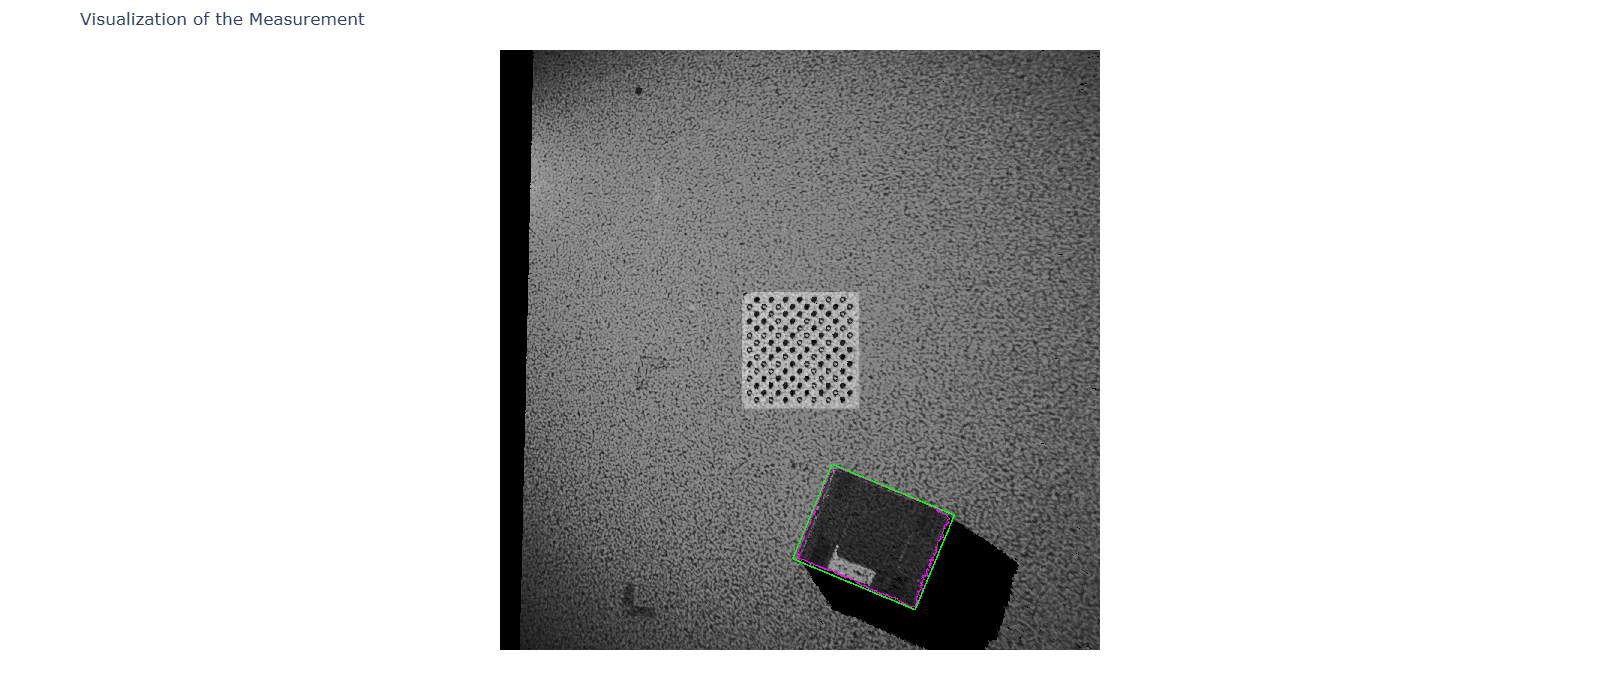

In [12]:
# Detect contours of all objects in the height image
contours, _ = cv2.findContours(binarized_height_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Select the contour/object with the largest area
center_in_img, size_in_img, angle, selected_index, max_area = 0, 0, 0, 0, 0
max_rect = None
for i, c in enumerate(contours):
    center_in_img, size_in_img, angle = cv2.minAreaRect(c)
    if max_area < size_in_img[0] * size_in_img[1]:
        selected_index = i
        max_area = size_in_img[0] * size_in_img[1]
        max_rect = (center_in_img, size_in_img, angle)

# Prepare height image with only the detected box in it
box_contour_mask = np.zeros_like(cleaned_height_image)
cv2.drawContours(box_contour_mask, contours, selected_index, color=1, thickness=-1)
height_image_box_only = height_image * box_contour_mask
height_image_box_only[height_image_box_only == 0] = np.nan

# Calculate the real size of the found object
length, width = size_in_img * PIXEL_SIZE_MM
height = np.nanmean(height_image_box_only)
precise_volume_dm3 = length * width * height / 1_000_000
center_pos = projected_point_map[int(center_in_img[0]), int(center_in_img[1]), :2]
print(f"Box Position: [{center_pos[0]:.1f}mm, {center_pos[1]:.1f}mm]; Rotation: {angle:.1f}°")
print(f"Box Size LWH: {length:.1f}mm x {width:.1f}mm x {height:.1f}mm (Volume: {precise_volume_dm3:.1f}L)")

# Plot
box = np.intp(cv2.boxPoints(max_rect))
cv2.drawContours(projected_texture, contours, selected_index, color=(255, 0, 255), thickness=2)
cv2.drawContours(projected_texture, [box], 0, (0, 255, 0), 3)
fig = go.Figure(go.Image(z=projected_texture))
fig.update_layout(
    title="Visualization of the Measurement",
    margin=dict(l=20, r=20, t=50, b=50),
    xaxis=dict(scaleanchor='y', scaleratio=1),
)
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()